In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import tskit
import sc2ts
import nb_utils

In [2]:
ts = nb_utils.load()
ti = sc2ts.TreeInfo(ts)

Loaded 731.5 megabyte SARS-CoV2 genealogy of 2482157 strains (345 trees, 1922947 mutations over 29904.0 basepairs). Last collection date is 2023-02-20


Counting descendants :   0%|          | 0/2689054 [00:00<?, ?it/s]

Indexing metadata    :   0%|          | 0/2689054 [00:00<?, ?it/s]

Classifying mutations:   0%|          | 0/1922947 [00:00<?, ?it/s]

In [3]:
data_dir = Path("../data")

In [4]:
recomb_file = data_dir / "recombinants.csv"
recomb_df = pd.read_csv(recomb_file)
recomb_df.columns

Index(['recombinant', 'descendants', 'sample', 'sample_id', 'sample_pango',
       'interval_left', 'interval_right', 'num_mutations', 'date_added',
       'group_id', 'parent_left', 'parent_left_pango', 'parent_right',
       'parent_right_pango', 'mrca', 't_mrca', 'diffs', 'max_run_length',
       'max_runlength_3sep', 'likely_artifactual', 'k4_num_mutations',
       'k1000_num_mutations', 'num_mutations_averted',
       'Viridian_amplicon_scheme', 'Platform', 'Artic_primer_version',
       'break_near_missing_run_12_7', 'net_min_supporting_loci_lft',
       'net_min_supporting_loci_rgt', 'net_min_supporting_loci_lft_rgt_ge_4',
       'parent_left_scorpio', 'parent_right_scorpio', 'sample_scorpio'],
      dtype='object')

In [5]:
sc2ts_file = data_dir / "bigtable_sc2ts.csv"
sc2ts_df = pd.read_csv(sc2ts_file)
sc2ts_df.columns

Index(['pango', 'github_issue', 'is_in_results', 'is_in_arg', 'is_in_matches',
       'is_clean', 'is_nested', 're_node', 'type', 'parent_left_pango',
       'parent_right_pango', 'parents_extra', 'interval_left',
       'interval_right', 'intervals_extra'],
      dtype='object')

In [6]:
def copying_table(
    self, node, hide_extra_rows=None, show_base=None, hide_labels=True, show_runlengths=True
):
    """
    Display bases that differ between the parents of a recombination node
    Mostly derived from the _copying_table() function in
    https://github.com/jeromekelleher/sc2ts/blob/main/sc2ts/info.py
    
    Parameters
    ----------
    node : int
        The node ID of the child node. This will be placed in the middle row.
    hide_extra_rows : bool or None
        If True, hide the rows that show the site positions, the reference sequence,
        and the de-novo mutations. If False or None (default), show these rows.
    show_base : bool or None
        If True, show the base at the node. If False, do not plot a character, but
        simply show coloured table cells. If None, show a dash for deletions
        and a dot for non-deleted bases in the child (to help indicate number of bases),
        but otherwise to not show a character.
    hide_labels: bool
        If False or None (default), label the rows with P0, P1, etc. If True, hide these
        row labels.
    show_runlengths : bool  
        If True, show a bar under the copying tables indicating adjacent bases.
    
    """
    def css_cell(allele, col, outline_sides=None, default_border_width=0):
        # function for the cell style - nucleotide colours faded from SNiPit
        css = f"border: {default_border_width}px solid black;  text-align: center; width: 1em;"
        if outline_sides is None:
            outline_sides = []
        elif isinstance(outline_sides, str):
             outline_sides = [outline_sides]
        for side in outline_sides:
            css += f"border{side}: 3px solid black;"
        css += "border-collapse: collapse; background-color:" + col
        return f' style="{css}"'

    def line_cell(show_line):
        if show_line:
            return '<td style="background: white; border-bottom: 3px solid red; "></td>'
        return '<td style="background: white;"></td>'

    def row_lab(txt):
        return "" if hide_labels else f"<th>{txt}</th>"

    def label(allele, default=""):
        if show_base is None:
            return ("<b>–</b>" if allele=="-" else default)
        if show_base:
            return allele
        return ''
        
    edges = tskit.EdgeTable()
    for e in sorted([self.ts.edge(i) for i in np.where(self.ts.edges_child==node)[0]], key=lambda e: e.left):
        edges.append(e)    
    vrl = ' style="writing-mode: vertical-rl; transform: rotate(180deg)"'

    parent_cols = {}
    samples = [node]
    for edge in edges:
        if edge.parent not in parent_cols:
            parent_cols[edge.parent] = len(parent_cols) + 1
            samples.append(edge.parent)

    # Can't have missing data here, so we're OK.
    variants = self.ts.variants(samples=samples, isolated_as_missing=False)
    mutations = self.node_mutations(node)

    positions = []
    ref = []
    runs = []
    parents = [[] for _ in range(len(parent_cols))]
    child = []
    extra_mut = []
    prev_pos = None
    prev_parent_col = None
    for var in variants:
        if len(np.unique(var.genotypes)) > 1:
            pos = int(var.site.position)
            if prev_pos is not None and pos == prev_pos + 1:
                runs[-1] = line_cell(True)
                runs.append(line_cell(True))
            else:
                runs.append(line_cell(False))
            positions.append(f"<td><span{vrl}>{pos}</span></td>")
            ref.append(f"<td>{var.site.ancestral_state}</td>")
            child_allele = var.alleles[var.genotypes[0]]

            edge_index = np.searchsorted(edges.left, pos, side="right") - 1
            parent_col = parent_cols[edges[edge_index].parent]
            is_switch = False if prev_parent_col is None else parent_col != prev_parent_col
            parent_colours = ["#FFF", "#8D8", "#6AD"]
            child_colours = parent_colours.copy()
            child_colours[0] = "#FC0"

            colour_index = set()
            for j in range(1, len(var.genotypes)):
                parent_allele = var.alleles[var.genotypes[j]]
                if parent_allele == child_allele:
                    colour_index.add(j)
            assert len(colour_index) < 2  # Only deal with 2 parents for now
            colour_index = colour_index.pop() if len(colour_index) else 0

            for j in range(1, len(var.genotypes)):
                parent_allele = var.alleles[var.genotypes[j]]
                col=parent_colours[0]
                if parent_allele == child_allele:
                    col = parent_colours[colour_index]
                elif parent_allele == var.site.ancestral_state:
                    col = "#DDD"
                outline_sides = []
                if j == parent_col:
                    outline_sides.append("-top" if j == 1 else "-bottom")
                if is_switch:
                    outline_sides.append("-left")
                css = css_cell(parent_allele, col, outline_sides)
                parents[j - 1].append(f"<td{css}>{label(parent_allele)}</td>")
                
            css = css_cell(
                child_allele,
                child_colours[colour_index],
                outline_sides="-left" if is_switch else None,
                #default_border_width=1  # uncomment to outline child bases with a border
            )
            child.append(f"<td{css}>{label(child_allele, ".")}</td>")
            extra_mut.append(f"<td><span{vrl}>{mutations.get(pos, '')}</span></td>")
            prev_pos = pos
            prev_parent_col = parent_col
    html = ""
    if not hide_extra_rows:
        html += '<tr style="font-size: 70%">' + row_lab("pos") + "".join(positions) + '</tr>'
        html += '<tr>' + row_lab("ref") + "".join(ref) + '</tr>'
    rowstyle = "font-size: 10px; border: 0px; height: 14px"
    html += f'<tr style="{rowstyle}">' + row_lab("P0") + "".join(parents.pop(0)) + '</tr>'
    html += f'<tr style="{rowstyle}">' + row_lab("C") + "".join(child) + '</tr>'
    for i, parent in enumerate(parents):
        html += f'<tr style="{rowstyle}">' + row_lab(f"P{i+1}") + "".join(parent) + '</tr>'
    if show_runlengths:
        html += "<tr style='font-size: 6px; height: 6px'>" + row_lab("") + "".join(runs) + "</tr>"
    if not hide_extra_rows:
        html += '<tr style="font-size: 75%">' + row_lab("mut") + "".join(extra_mut) + "</tr>"

    return f"<table style='border-spacing: 0px'>{html}</table>"

In [58]:
from PIL import Image
import imgkit  # To convert the HTML table to a PNG. Also needs wkhtmltox to be installed
import io


copying_images = {
    #"XA": {'id': 122444},
    "bad1": {'id': recomb_df.recombinant[38]},
    "bad2": {'id': recomb_df.recombinant[130]},
    "bad3": {'id': recomb_df.recombinant[110]},
    "good": {'id': recomb_df.recombinant[5]},
}

for label, val in copying_images.items():
    img = imgkit.from_string(
        copying_table(ti, val['id'], hide_extra_rows=True, hide_labels=True),
        False,  # return the bytes, rather than saving to file
        options={"width": 800})
    val['img'] = np.asarray(Image.open(io.BytesIO(img)))

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


In [59]:
def draw_copying_patterns(copying_images, ax, x_scale=1):
    #copying_images["XA"]["pos"] = [0, 0.00, x_scale, 1]
    copying_images["bad1"]["pos"] = [0.2, 0.4, x_scale, 1]
    copying_images["bad2"]["pos"] = [0.2, 0.2, x_scale, 1]
    copying_images["bad3"]["pos"] = [0.2, 0.0, x_scale, 1]
    copying_images["good"]["pos"] = [0.2, -0.2, x_scale, 1]
    ax.axis("off")
    for label, val in copying_images.items():
        ax_image = ax.inset_axes(val["pos"])
        ax_image.imshow(val["img"])
        ax_image.axis('off')  # Remove axis of the image
        ax_image.text(5, 40, label, fontsize=15, ha="right")

In [60]:
from collections import Counter
Counter(recomb_df.Viridian_amplicon_scheme)

Counter({'COVID-AMPLISEQ-V1': 382,
         'COVID-ARTIC-V4.1': 353,
         'COVID-ARTIC-V3': 176,
         'COVID-VARSKIP-V1a-2b': 17,
         'COVID-MIDNIGHT-1200': 1})

In [61]:
import matplotlib.colors as mcolors
colorpal = {
    "COVID-ARTIC-V3": mcolors.TABLEAU_COLORS["tab:blue"],
    "COVID-ARTIC-V4.1": mcolors.TABLEAU_COLORS["tab:green"],
    "COVID-AMPLISEQ-V1": mcolors.TABLEAU_COLORS["tab:red"],
    'COVID-VARSKIP-V1a-2b': mcolors.TABLEAU_COLORS["tab:orange"],
    'COVID-MIDNIGHT-1200': mcolors.TABLEAU_COLORS["tab:pink"],
}

/var/folders/4h/9ylb643n37d8jc7srjm7qzk00000gr/T/ipykernel_96207/520922941.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  a[a <= 0] = m1_coord
/var/folders/4h/9ylb643n37d8jc7srjm7qzk00000gr/T/ipykernel_96207/520922941.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  b[b <= 0] = m1_coord


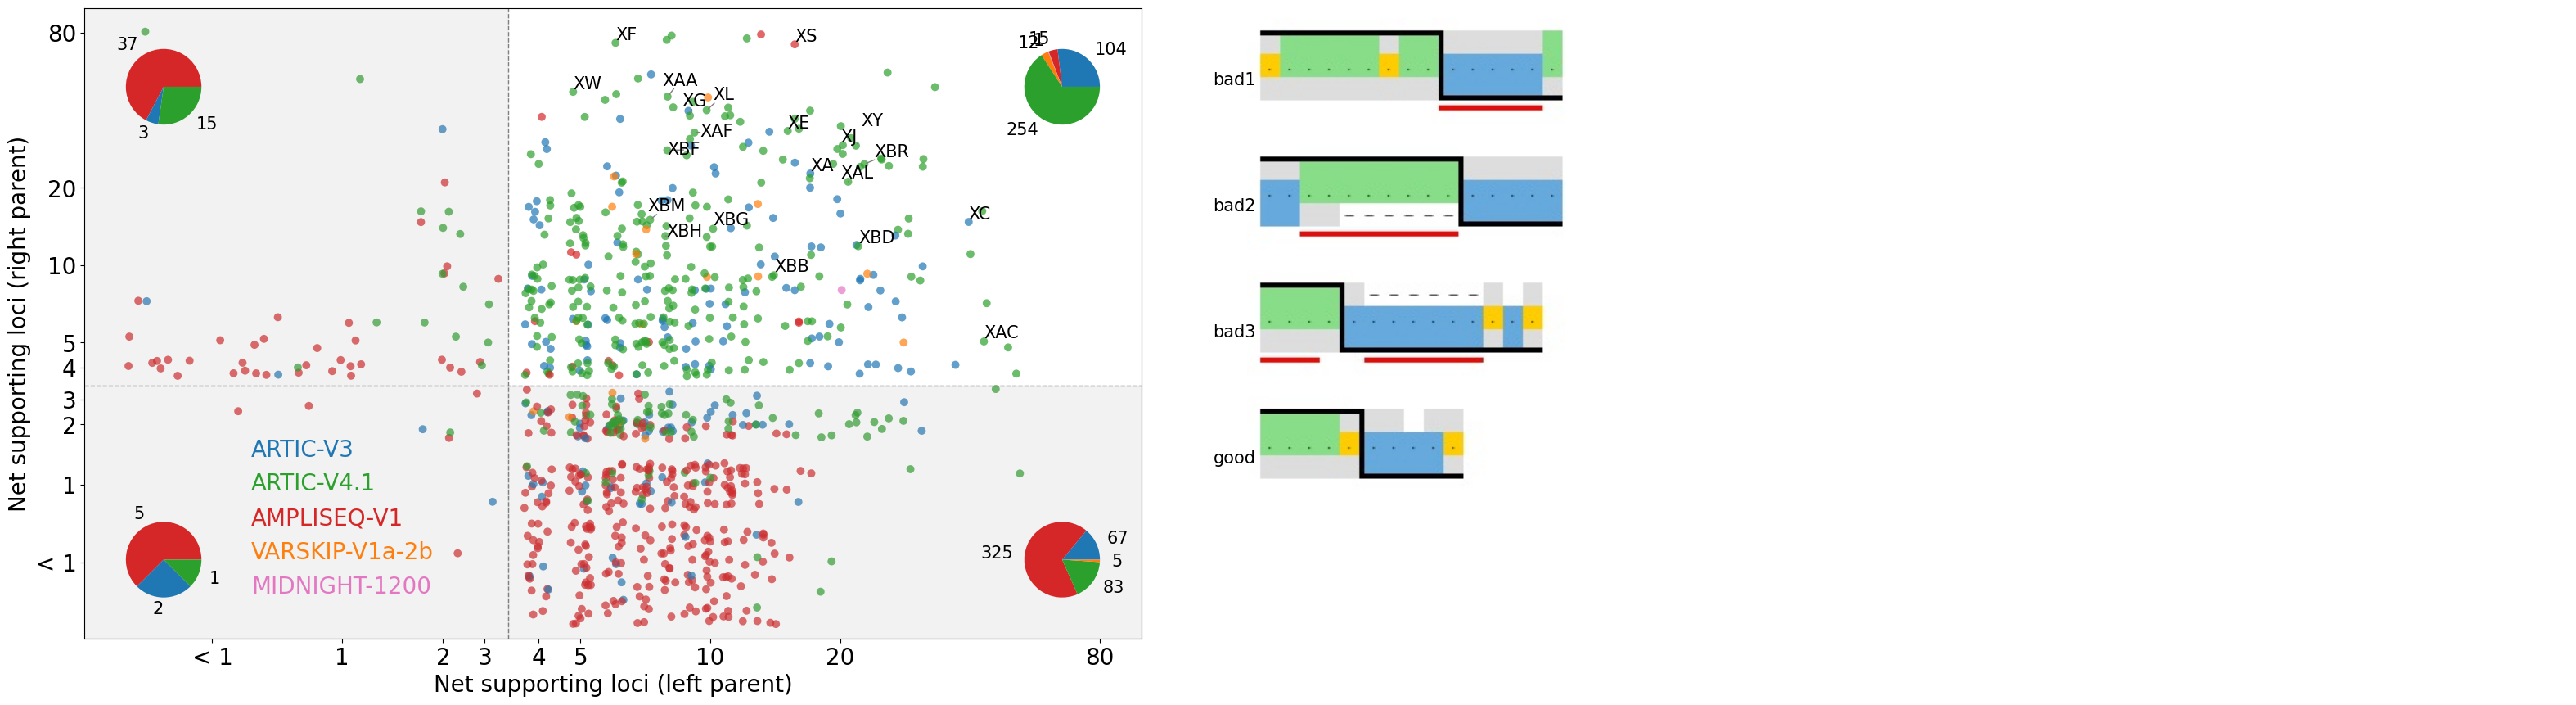

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import adjustText


j_width = 0.3
j1 = np.random.uniform(-j_width, j_width, len(recomb_df))
j2 = np.random.uniform(-j_width, j_width, len(recomb_df))

m1_coord = 0.7
adj_coord = 0.4

a = recomb_df.net_min_supporting_loci_lft.copy()
b = recomb_df.net_min_supporting_loci_rgt.copy()
a[a <= 0] = m1_coord
b[b <= 0] = m1_coord
a[a == 1] = 1 + adj_coord
b[b == 1] = 1 + adj_coord
a[a == 2] = 2 + adj_coord
b[b == 2] = 2 + adj_coord
x = a + j1
y = b + j2


fontsize = 20

fig = plt.figure(figsize=(25, 10))
gs = GridSpec(nrows=2, ncols=3, figure=fig, wspace=0)

scatter_ax = fig.add_subplot(gs[:, :2])
copypatt_ax = fig.add_subplot(gs[:, 2])

scatter_ax.tick_params(axis='both', which='major', labelsize=fontsize)
xticks = [m1_coord, 1 + adj_coord, 2 + adj_coord, 3, 4, 5, 10, 20, 80]
xtick_labels = ["< 1", "1", "2"] + [str(x) for x in xticks[3:]]
scatter_ax.set_xticks(ticks=np.log2(xticks), labels=xtick_labels, fontsize=fontsize)
yticks = [m1_coord, 1 + adj_coord, 2 + adj_coord, 3, 4, 5, 10, 20, 80]
ytick_labels = ["< 1", "1", "2"] + [str(y) for y in yticks[3:]]
scatter_ax.set_yticks(ticks=np.log2(yticks), labels=ytick_labels, fontsize=fontsize)

texts = []
for (xx, yy, row) in zip(x, y, recomb_df.itertuples()):
    if any(sc2ts_df.re_node == row.recombinant):
        label = sc2ts_df.pango[sc2ts_df.re_node == row.recombinant].iloc[0]
        texts.append(scatter_ax.text(x=np.log2(xx), y=np.log2(yy), s=label, fontsize=15))

scatter_ax.scatter(
    x=np.log2(x),
    y=np.log2(y),
    c=[colorpal[x] for x in recomb_df.Viridian_amplicon_scheme],
    s=50,
    alpha=0.7,
    linewidths=0,
)

adjustText.adjust_text(
    texts,
    arrowprops=dict(arrowstyle="-", color="gray", shrinkA=15, lw=1),
    ax=scatter_ax,
)

scatter_ax.axvline(np.log2(3 + adj_coord), linestyle="--", linewidth=1, color="gray")
scatter_ax.axhline(np.log2(3 + adj_coord), linestyle="--", linewidth=1, color="gray")
scatter_ax.set_xlim(-1.5, np.log2(100))
scatter_ax.set_ylim(-1.5, np.log2(100))
scatter_ax.set_xlabel('Net supporting loci (left parent)', fontsize=fontsize)
scatter_ax.set_ylabel('Net supporting loci (right parent)', fontsize=fontsize)

fx = np.array([-1.5, np.log2(3 + adj_coord)])
fy1 = np.array([np.log2(100), np.log2(100)])
fy2 = np.array([-1.5, -1.5])
scatter_ax.fill_between(fx, fy1, fy2, where=(fy1 > fy2), color="gray", alpha=0.1)

fx = np.array([np.log2(3 + adj_coord), np.log2(100)])
fy1 = np.array([np.log2(3 + adj_coord), np.log2(3 + adj_coord)])
fy2 = np.array([-1.5, -1.5])
scatter_ax.fill_between(fx, fy1, fy2, where=(fy1 > fy2), color="gray", alpha=0.1)

empty_patch = mpatches.Patch(color='none', label='')
scatter_ax.legend(
    labels=[x.replace("COVID-", "") for x in colorpal.keys()],
    labelcolor=colorpal.values(),
    handles=[empty_patch for _ in colorpal.keys()],
    bbox_to_anchor=(0.35, 0.35),
    fontsize=fontsize,
    frameon=False,
)


def plot_inset_pie(ax, wedge_sizes, labels, colors, labeldistance=1.3, fontsize=15):
    ax.pie(
        x=wedge_sizes,
        labels=labels,
        colors=colors,
        labeldistance=labeldistance,
        textprops={"fontsize": fontsize},
    )


inset_size = 0.15

ax_upper_left = scatter_ax.inset_axes([0.0, 0.8, inset_size, inset_size])
w = Counter(recomb_df.Viridian_amplicon_scheme[np.logical_and(a < 4, b >= 4)])
plot_inset_pie(
    ax=ax_upper_left,
    wedge_sizes=w.values(),
    labels=[str(x) for x in w.values()],
    colors=[colorpal[x] for x in w.keys()],
)
ax_upper_right = scatter_ax.inset_axes([0.85, 0.8, inset_size, inset_size])
w = Counter(recomb_df.Viridian_amplicon_scheme[np.logical_and(a >= 4, b >= 4)])
plot_inset_pie(
    ax=ax_upper_right,
    wedge_sizes=w.values(),
    labels=[str(x) for x in w.values()],
    colors=[colorpal[x] for x in w.keys()],
)
ax_bottom_left = scatter_ax.inset_axes([0.0, 0.05, inset_size, inset_size])
w = Counter(recomb_df.Viridian_amplicon_scheme[np.logical_and(a < 4, b < 4)])
plot_inset_pie(
    ax=ax_bottom_left,
    wedge_sizes=w.values(),
    labels=[str(x) for x in w.values()],
    colors=[colorpal[x] for x in w.keys()],
)
ax_bottom_right = scatter_ax.inset_axes([0.85, 0.05, inset_size, inset_size])
w = Counter(recomb_df.Viridian_amplicon_scheme[np.logical_and(a >= 4, b < 4)])
plot_inset_pie(
    ax=ax_bottom_right,
    wedge_sizes=w.values(),
    labels=[str(x) for x in w.values()],
    colors=[colorpal[x] for x in w.keys()],
)

draw_copying_patterns(copying_images, copypatt_ax, x_scale=2.5)

plt.savefig("Fig3.pdf", format='pdf', dpi=600, transparent=True);